In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [10]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [11]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        contour_image = self.get_contour_from_mask_tensor(mask_tensor)
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, contour_image, mask_name, image_type
    def get_contour_from_mask_tensor(self, mask_tensor):
        """
        Extract contours from a transformed segmentation mask tensor.
        Args:
            mask_tensor (torch.Tensor): Shape (1, H, W) or (H, W)
        Returns:
            contours: List of contour points
            contour_image: Image with contours drawn (for visualization)
        """
        # Remove channel if exists and convert to NumPy
        if mask_tensor.dim() == 3:
            mask_np = mask_tensor.squeeze().cpu().numpy()
        else:
            mask_np = mask_tensor.cpu().numpy()
    
        # Binarize and convert to uint8
        mask_bin = (mask_np > 0.5).astype(np.uint8) * 255
    
        # OpenCV expects a CV_8UC1 image
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Optional: visualize the contour
        contour_image = np.zeros_like(mask_bin)
        cv2.drawContours(contour_image, contours, -1, 255, thickness=3)
        contour_image = contour_image.astype(np.float32) / 255.0
        
        contour_image = torch.tensor(contour_image)
        contour_image = torch.unsqueeze(contour_image, 0)
    
        return contour_image

In [18]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = train_augmentation, image_size = image_size)
# train_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
# test_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, contour, mask_name, image_type = next(iter(test_dataloader))

video_000055_1729840320334.mp4#t=4.933333.png
test


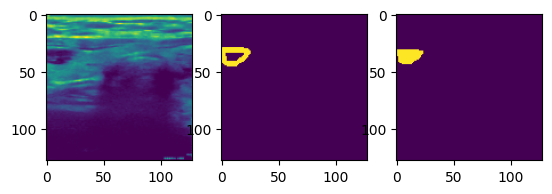

video_000058_1729844840454.mp4#t=2.4.png
test


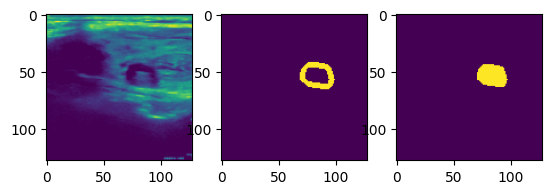

video_000055_1729840363438.mp4#t=0.866667.png
test


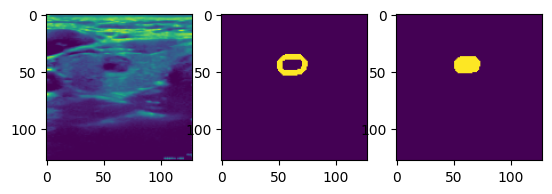

video_000058_1729844797982.mp4#t=9.6.png
test


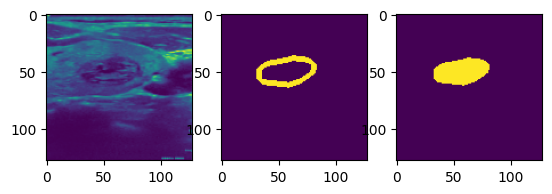

video_000056_1729842220863.mp4#t=1.8.png
test


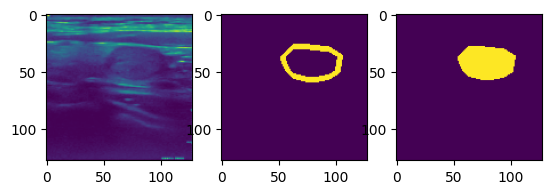

video_000058_1729844828112.mp4#t=8.933333.png
test


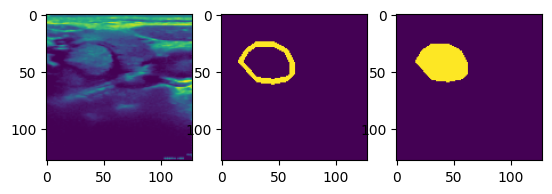

video_000058_1729844840454.mp4#t=3.066667.png
test


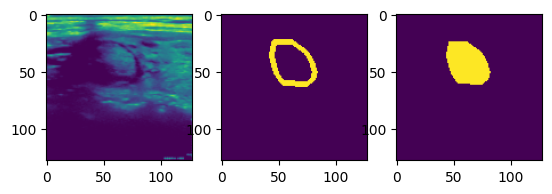

video_000058_1729844809827.mp4#t=6.066667.png
test


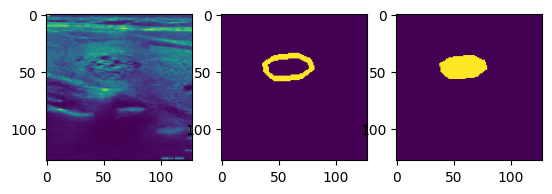

video_000056_1729842935734.mp4#t=1.2.png
test


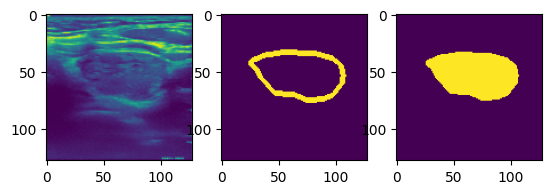

video_000055_1729840320334.mp4#t=9.6.png
test


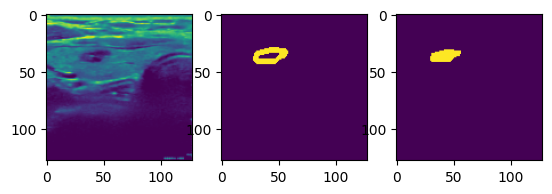

video_000055_1729840338149.mp4#t=9.6.png
test


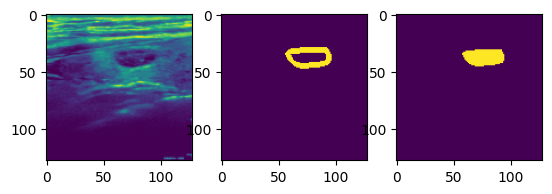

video_000055_1729840320334.mp4#t=6.866667.png
test


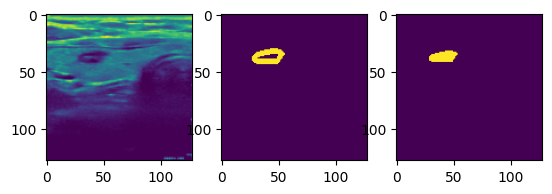

video_000056_1729842914782.mp4#t=2.png
test


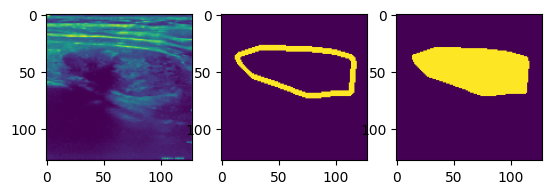

video_000055_1729840379928.mp4#t=7.4.png
test


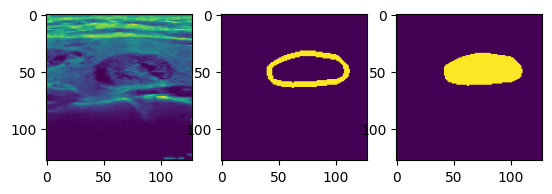

video_000055_1729840363438.mp4#t=2.6.png
test


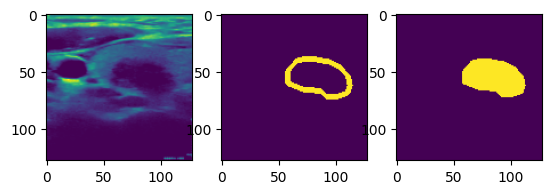

video_000058_1729844809827.mp4#t=6.466667.png
test


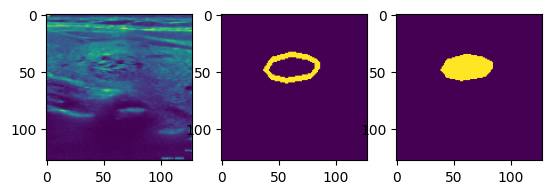

video_000056_1729842914782.mp4#t=1.066667.png
test


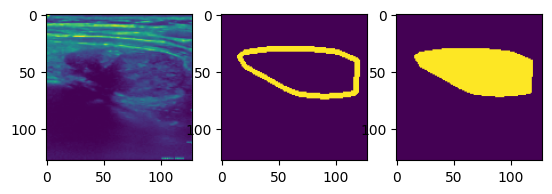

video_000055_1729840379928.mp4#t=6.2.png
test


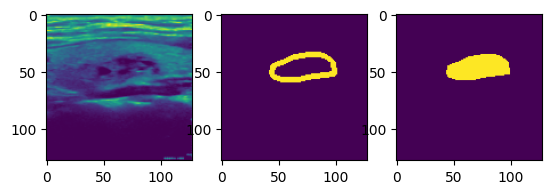

video_000056_1729842935734.mp4#t=9.6.png
test


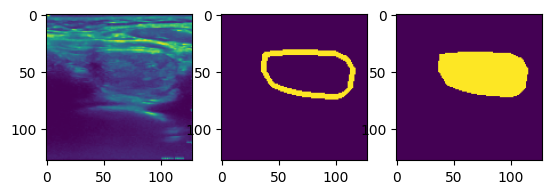

video_000056_1729842220863.mp4#t=8.133333.png
test


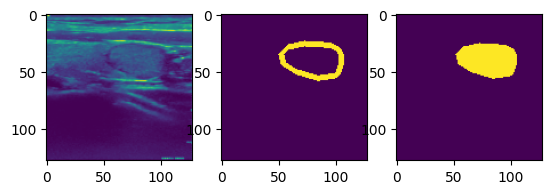

In [19]:
for i in range(20):
    print(mask_name[i])
    print(image_type[i])
    plt.subplot(1,3,1)
    plt.imshow(image[i][0])
    plt.subplot(1,3,2)
    plt.imshow(contour[i][0])
    plt.subplot(1,3,3)
    plt.imshow(mask[i][0])
    plt.show()
    

In [20]:
print(len(train_dataset), len(test_dataset))

169 112


In [40]:
def train(dataloader, model, optimizer, image_loss_fn, contour_loss_fn, device):
    total_loss = 0
    image_total_loss = 0
    contour_total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, contour, mask_name, image_type in tqdm(dataloader):
        image, mask, contour = image.to(device), mask.to(device), contour.to(device)
        
        outputs = model(image)
        
        nodule_image = outputs[:, 0:1, :, :]
        nodule_contour = outputs[:, 2:3, :, :]
        
        image_loss = image_loss_fn(nodule_image, mask)
        contour_loss = contour_loss_fn(nodule_contour, contour)
        
        loss = image_loss + contour_loss

        IOU = IOU_score(nodule_image, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_image, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        image_total_loss += image_loss.item()
        contour_total_loss += contour_loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), image_total_loss/len(dataloader), contour_total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, image_loss_fn, contour_loss_fn, device):
    total_loss = 0
    image_total_loss = 0
    contour_total_loss = 0
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, contour, mask_name, image_type in tqdm(dataloader):
        image, mask, contour = image.to(device), mask.to(device), contour.to(device)
        
        outputs = model(image)
        
        nodule_image = outputs[:, 0:1, :, :]
        nodule_contour = outputs[:, 2:3, :, :]
        
        image_loss = image_loss_fn(nodule_image, mask)
        contour_loss = contour_loss_fn(nodule_contour, contour)
        
        loss = image_loss + contour_loss

        IOU = IOU_score(nodule_image, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_image, mask)


        total_loss += loss.item()
        image_total_loss += image_loss.item()
        contour_total_loss += contour_loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
    return total_loss/len(dataloader), image_total_loss/len(dataloader), contour_total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)



    

In [41]:

inference_name = "hybrid_v3_contour_1_decoder_equal_loss"

model = HybridSegModel(in_channels = 1, out_channels = 4, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [42]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [43]:

epochs = 500
lr = 0.005
image_loss_fn = StructureLoss()
contour_loss_fn = DiceLoss(need_act = True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [44]:

project = "thyroid_ge_finetune"
name = "hybrid_v3_contour_1_decoder_equal_loss(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [45]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, image_total_loss_train, contour_total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, image_loss_fn, contour_loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, image_total_loss_val, contour_total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, image_loss_fn, contour_loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "image_train_loss": image_total_loss_train,
        "contour_train_loss": contour_total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "image_val_loss": image_total_loss_val,
        "contour_val_loss": contour_total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 2.987921953201294, train IOU : 0.30756067484617233, train DICE : 0.48655378818511963


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 1.040927529335022, val IOU : 0.6616798639297485, val DICE : 0.7647389769554138
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 1.6588244438171387, train IOU : 0.3140809237957001, train DICE : 0.4279291331768036


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.1958359479904175, val IOU : 0.5655592083930969, val DICE : 0.7118661999702454
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 1.4210798740386963, train IOU : 0.4782651662826538, train DICE : 0.5801447331905365


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.216616153717041, val IOU : 0.6119846701622009, val DICE : 0.7404050230979919
epoch : 3


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 1.2333030700683594, train IOU : 0.5356251299381256, train DICE : 0.6699569821357727


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 1.0759721994400024, val IOU : 0.6613482236862183, val DICE : 0.7700855731964111
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 1.26004558801651, train IOU : 0.4771087020635605, train DICE : 0.6335664093494415


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 1.106443166732788, val IOU : 0.6356276869773865, val DICE : 0.7379076480865479
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 1.1655343174934387, train IOU : 0.5144722163677216, train DICE : 0.6696273684501648


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 1.0786349773406982, val IOU : 0.6543898582458496, val DICE : 0.7544784545898438
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 1.1845702528953552, train IOU : 0.5189370810985565, train DICE : 0.6721543073654175


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 1.0148422718048096, val IOU : 0.6560884118080139, val DICE : 0.7677778601646423
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 1.1603958010673523, train IOU : 0.5404507517814636, train DICE : 0.6842327117919922


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.9758435487747192, val IOU : 0.6842964887619019, val DICE : 0.7872945666313171
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 1.060502827167511, train IOU : 0.5924894213676453, train DICE : 0.7318499684333801


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.9740995168685913, val IOU : 0.7034273147583008, val DICE : 0.7987030744552612
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 1.0857168436050415, train IOU : 0.564426988363266, train DICE : 0.7117490172386169


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.9721218347549438, val IOU : 0.6730443835258484, val DICE : 0.7681591510772705
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 1.1682584285736084, train IOU : 0.527778148651123, train DICE : 0.6831196844577789


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.9905169606208801, val IOU : 0.6576951146125793, val DICE : 0.7473753690719604
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 1.0449336171150208, train IOU : 0.5733266472816467, train DICE : 0.7083442807197571


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.9420315623283386, val IOU : 0.6983098387718201, val DICE : 0.7735455632209778
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 1.0871552228927612, train IOU : 0.5628959238529205, train DICE : 0.6940710842609406


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.9143143892288208, val IOU : 0.7080550193786621, val DICE : 0.7805132865905762
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 1.0337190628051758, train IOU : 0.5988580286502838, train DICE : 0.7006678581237793


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.931882381439209, val IOU : 0.6788554787635803, val DICE : 0.7552269101142883
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 1.0387229919433594, train IOU : 0.5767021477222443, train DICE : 0.6983875334262848


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.8544479608535767, val IOU : 0.720747172832489, val DICE : 0.7924243807792664
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 1.0325745344161987, train IOU : 0.5880092978477478, train DICE : 0.702694833278656


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7964175343513489, val IOU : 0.7447218298912048, val DICE : 0.8161354660987854
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.9496107697486877, train IOU : 0.6053945124149323, train DICE : 0.719111979007721


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7759672999382019, val IOU : 0.735253632068634, val DICE : 0.8059248328208923
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.9741936326026917, train IOU : 0.5951029658317566, train DICE : 0.7186257243156433


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7609074711799622, val IOU : 0.7362303733825684, val DICE : 0.8069133758544922
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.9466448426246643, train IOU : 0.5810592174530029, train DICE : 0.7094173431396484


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7524148225784302, val IOU : 0.7414571642875671, val DICE : 0.8116015195846558
epoch : 19


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.9326664209365845, train IOU : 0.6423701345920563, train DICE : 0.7449841797351837


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7488227486610413, val IOU : 0.7456704378128052, val DICE : 0.8155044317245483
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.9108244180679321, train IOU : 0.5999087393283844, train DICE : 0.7242553532123566


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7591108083724976, val IOU : 0.7391564249992371, val DICE : 0.8074798583984375
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.9120435118675232, train IOU : 0.6130203604698181, train DICE : 0.7261209189891815


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7596884965896606, val IOU : 0.7461056113243103, val DICE : 0.8166207671165466
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8758580982685089, train IOU : 0.6250196695327759, train DICE : 0.7381141781806946


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.7662758231163025, val IOU : 0.7441878914833069, val DICE : 0.815671980381012
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8770101368427277, train IOU : 0.6428152918815613, train DICE : 0.7450855374336243


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7528858184814453, val IOU : 0.7420032620429993, val DICE : 0.81014484167099
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.8888323605060577, train IOU : 0.6221116483211517, train DICE : 0.7222775816917419


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.7568924427032471, val IOU : 0.743252158164978, val DICE : 0.8115360140800476
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.8614042103290558, train IOU : 0.6322251558303833, train DICE : 0.747982382774353


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7778509259223938, val IOU : 0.7454007267951965, val DICE : 0.8179609179496765
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.8421301245689392, train IOU : 0.6659555435180664, train DICE : 0.7436303794384003


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7635880708694458, val IOU : 0.7456698417663574, val DICE : 0.8143662214279175
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8990156948566437, train IOU : 0.6260219216346741, train DICE : 0.7386429905891418


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7734782099723816, val IOU : 0.7375369668006897, val DICE : 0.8041545748710632
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.9424895644187927, train IOU : 0.5898425877094269, train DICE : 0.7231984436511993


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7621982097625732, val IOU : 0.7412093281745911, val DICE : 0.8094768524169922
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8451943695545197, train IOU : 0.6297867596149445, train DICE : 0.727421224117279


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.772906482219696, val IOU : 0.7463467121124268, val DICE : 0.8200598359107971
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.8377063274383545, train IOU : 0.6465291678905487, train DICE : 0.7541714012622833


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7652119398117065, val IOU : 0.7475516200065613, val DICE : 0.8208671808242798
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.7945193648338318, train IOU : 0.6709865629673004, train DICE : 0.770760178565979


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7555774450302124, val IOU : 0.7426236271858215, val DICE : 0.8148506879806519
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.8064122498035431, train IOU : 0.6537810564041138, train DICE : 0.7662026584148407


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7556408047676086, val IOU : 0.7497674226760864, val DICE : 0.8246988654136658
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.8723631501197815, train IOU : 0.6468505561351776, train DICE : 0.7435592710971832


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7533564567565918, val IOU : 0.7499743700027466, val DICE : 0.8250356316566467
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8624323010444641, train IOU : 0.6424841582775116, train DICE : 0.7625040113925934


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7639805674552917, val IOU : 0.7358404397964478, val DICE : 0.8120010495185852
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8549280166625977, train IOU : 0.6056825816631317, train DICE : 0.7277520000934601


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7818503379821777, val IOU : 0.739000141620636, val DICE : 0.8187403678894043
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.8108345568180084, train IOU : 0.66258305311203, train DICE : 0.7598268985748291


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.833441972732544, val IOU : 0.7272053360939026, val DICE : 0.8119547367095947
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.7996859550476074, train IOU : 0.6568199098110199, train DICE : 0.7586680352687836


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7817731499671936, val IOU : 0.7272530794143677, val DICE : 0.8065491318702698
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.8005585670471191, train IOU : 0.6645170152187347, train DICE : 0.7685245871543884


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.7711525559425354, val IOU : 0.7326761484146118, val DICE : 0.810631275177002
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.8059526681900024, train IOU : 0.6849813461303711, train DICE : 0.7573859095573425


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.7565745115280151, val IOU : 0.7398391366004944, val DICE : 0.8161895871162415
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.7792491614818573, train IOU : 0.655619204044342, train DICE : 0.7680143415927887


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.7461944818496704, val IOU : 0.7412852644920349, val DICE : 0.8166623711585999
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.8286259174346924, train IOU : 0.627179890871048, train DICE : 0.7347899377346039


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.7584223747253418, val IOU : 0.7473387718200684, val DICE : 0.8231275081634521
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.8298725783824921, train IOU : 0.6514333188533783, train DICE : 0.7528037428855896


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.7475671768188477, val IOU : 0.7436473369598389, val DICE : 0.8180175423622131
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.7487592995166779, train IOU : 0.6720243394374847, train DICE : 0.7804306745529175


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.7441315650939941, val IOU : 0.7394791841506958, val DICE : 0.813538134098053
epoch : 44


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.7151443362236023, train IOU : 0.6963958740234375, train DICE : 0.7885802388191223


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7499240040779114, val IOU : 0.7485180497169495, val DICE : 0.823398768901825
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.7501047253608704, train IOU : 0.6792189180850983, train DICE : 0.7791927754878998


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7499006986618042, val IOU : 0.7474188208580017, val DICE : 0.8230146169662476
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.7240636348724365, train IOU : 0.7068633735179901, train DICE : 0.795341819524765


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7297931909561157, val IOU : 0.7464412450790405, val DICE : 0.821844220161438
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.7561066448688507, train IOU : 0.6784111261367798, train DICE : 0.7843410074710846


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7321246862411499, val IOU : 0.7503533363342285, val DICE : 0.8266353607177734
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.737815797328949, train IOU : 0.6747491955757141, train DICE : 0.7635904848575592


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7453019618988037, val IOU : 0.7521433234214783, val DICE : 0.8292505741119385
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.7396054565906525, train IOU : 0.6889869868755341, train DICE : 0.7793914675712585


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7342087030410767, val IOU : 0.7481964826583862, val DICE : 0.8240714073181152
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.740009605884552, train IOU : 0.671256810426712, train DICE : 0.7751190662384033


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.7419164180755615, val IOU : 0.7425034642219543, val DICE : 0.8194506764411926
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.7291124761104584, train IOU : 0.6942903995513916, train DICE : 0.7809328436851501


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.7466491460800171, val IOU : 0.7418649196624756, val DICE : 0.8209389448165894
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.7225129008293152, train IOU : 0.6893842220306396, train DICE : 0.797461748123169


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.7280540466308594, val IOU : 0.742378294467926, val DICE : 0.8226205706596375
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.6765982210636139, train IOU : 0.7020111978054047, train DICE : 0.7929902374744415


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.7266384363174438, val IOU : 0.749222993850708, val DICE : 0.8305508494377136
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.6841548681259155, train IOU : 0.6995940208435059, train DICE : 0.8050206005573273


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.729282021522522, val IOU : 0.7519892454147339, val DICE : 0.8344694972038269
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.788901150226593, train IOU : 0.6808086335659027, train DICE : 0.7735138833522797


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7243807315826416, val IOU : 0.7386290431022644, val DICE : 0.8200414776802063
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.7183007001876831, train IOU : 0.6919401288032532, train DICE : 0.7850818932056427


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7198325991630554, val IOU : 0.7518830895423889, val DICE : 0.8336787819862366
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.703873336315155, train IOU : 0.7027581632137299, train DICE : 0.7988313138484955


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.7557606101036072, val IOU : 0.7520535588264465, val DICE : 0.836865246295929
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.7180817723274231, train IOU : 0.6809807419776917, train DICE : 0.7799653112888336


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.7141103744506836, val IOU : 0.7476148009300232, val DICE : 0.8309636116027832
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.6816765069961548, train IOU : 0.6923102140426636, train DICE : 0.8005513548851013


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7143522500991821, val IOU : 0.7528399229049683, val DICE : 0.8357174396514893
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.7017458081245422, train IOU : 0.7199094891548157, train DICE : 0.813396543264389


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.71620774269104, val IOU : 0.7411538362503052, val DICE : 0.8244755268096924
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.7099357843399048, train IOU : 0.6832635700702667, train DICE : 0.7838672399520874


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7439761161804199, val IOU : 0.7269589304924011, val DICE : 0.808648407459259
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.712944746017456, train IOU : 0.6616734266281128, train DICE : 0.7802751064300537


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7693430185317993, val IOU : 0.7399023175239563, val DICE : 0.8242064714431763
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.7011384963989258, train IOU : 0.6992104053497314, train DICE : 0.8035140633583069


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.7847289443016052, val IOU : 0.7392535209655762, val DICE : 0.8251072764396667
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.7302266955375671, train IOU : 0.7060976326465607, train DICE : 0.8015247285366058


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7486268281936646, val IOU : 0.731681764125824, val DICE : 0.8106859922409058
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.7048800885677338, train IOU : 0.6922590136528015, train DICE : 0.7930767834186554


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7196952700614929, val IOU : 0.7471973299980164, val DICE : 0.8284016251564026
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.736051082611084, train IOU : 0.6989916265010834, train DICE : 0.7973855137825012


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.7287247776985168, val IOU : 0.7532999515533447, val DICE : 0.8366801142692566
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.6654618382453918, train IOU : 0.7223931849002838, train DICE : 0.8172015845775604


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.7367374300956726, val IOU : 0.7434611320495605, val DICE : 0.8256592750549316
epoch : 68


  0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

NameError: name 'HybridSegModel' is not defined

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")